In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, shapiro

df = pd.read_csv("data.csv")

# Load Data
df.head()
df.info()

# Missing Values
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


class                  0
ID                     0
air_time1              0
disp_index1            0
pressure_mean23        0
                      ..
mean_acc_in_air1       0
mean_acc_on_paper1     0
mean_gmrt1             0
mean_jerk_in_air1      0
mean_jerk_on_paper1    0
Length: 452, dtype: int64

(174, 452)
float64    300
int64      150
object       2
Name: count, dtype: int64
class
P    89
H    85
Name: count, dtype: int64


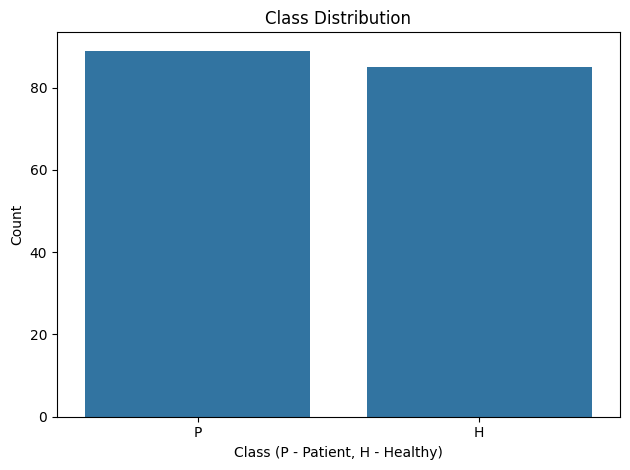

In [3]:
# Data overview
print(df.shape)
print(df.dtypes.value_counts())
print(df['class'].value_counts())

# Summary statistics by class
grouped = df.groupby('class')
desc_stats = grouped.describe().T

# Class Distribution between Patients and Healthy
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.xlabel("Class (P - Patient, H - Healthy)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

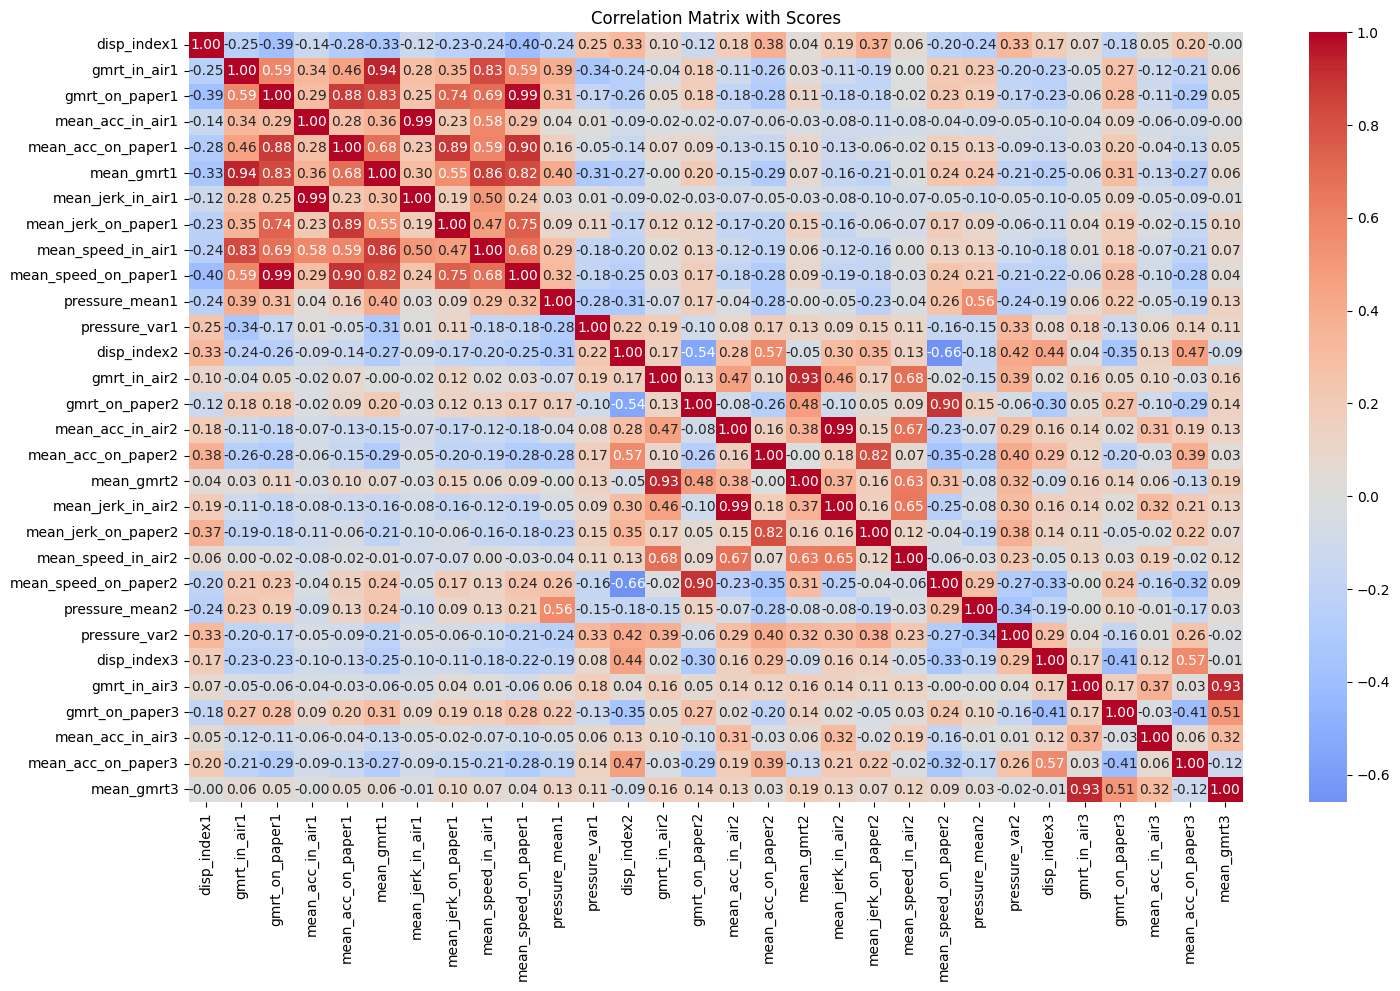

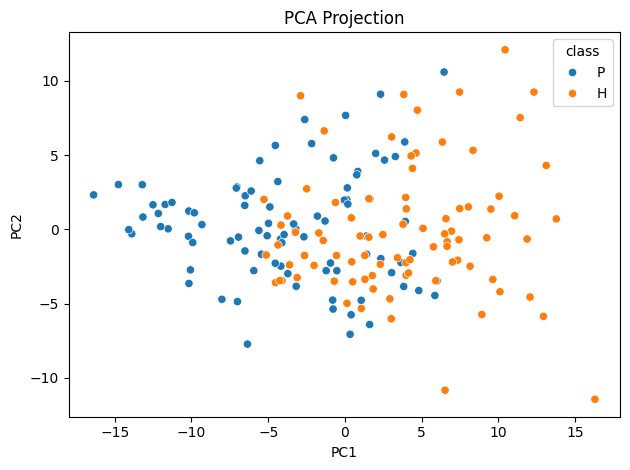

In [10]:
# Correlation heatmap with annotated scores
float_cols = df.select_dtypes(include='float64').columns
corr = df[float_cols].corr()

plt.figure(figsize=(17, 10))
sns.heatmap(corr.iloc[:30, :30], cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix with Scores")
plt.show()

# PCA for visualization
X = df[float_cols].fillna(0)
y = df['class']
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['class'] = y.values

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='class')
plt.title("PCA Projection")
plt.tight_layout()
plt.show()


Top Features:
['gmrt_in_air7', 'mean_gmrt7', 'mean_speed_in_air7', 'gmrt_on_paper17', 'mean_acc_in_air17', 'mean_gmrt17', 'mean_jerk_in_air17', 'mean_speed_in_air17', 'disp_index22', 'disp_index23']


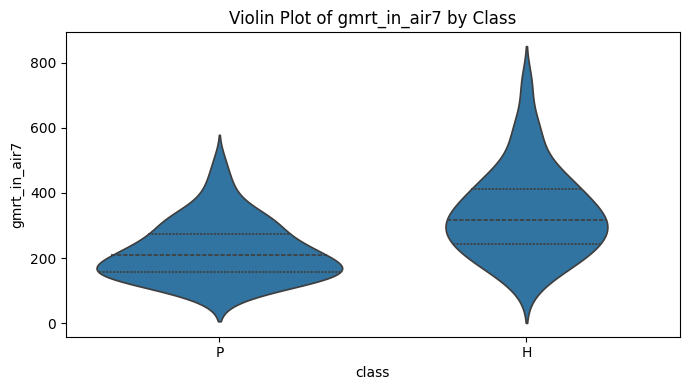

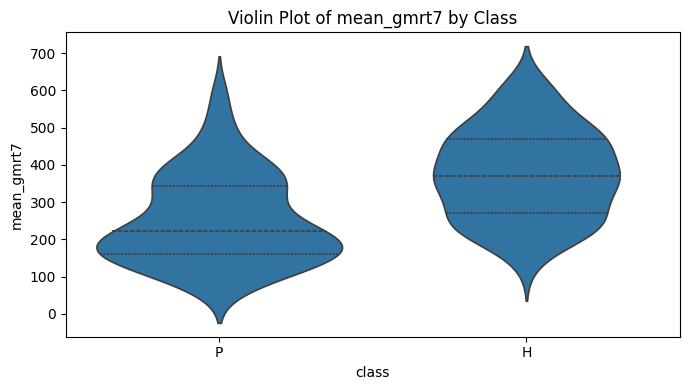

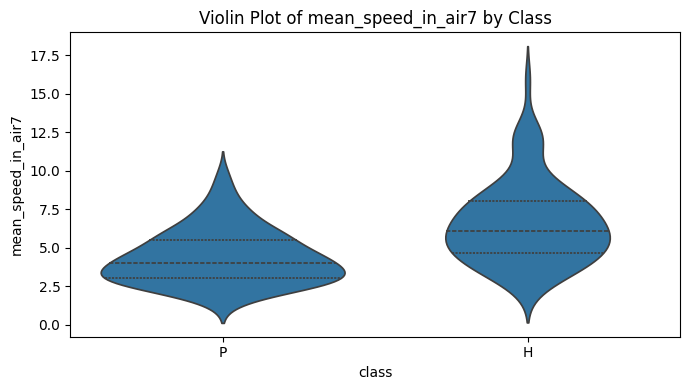

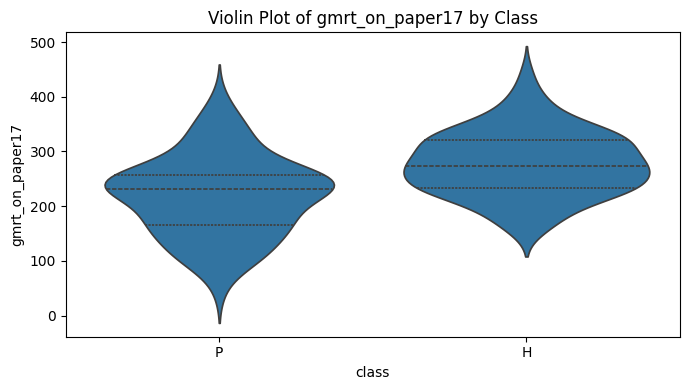

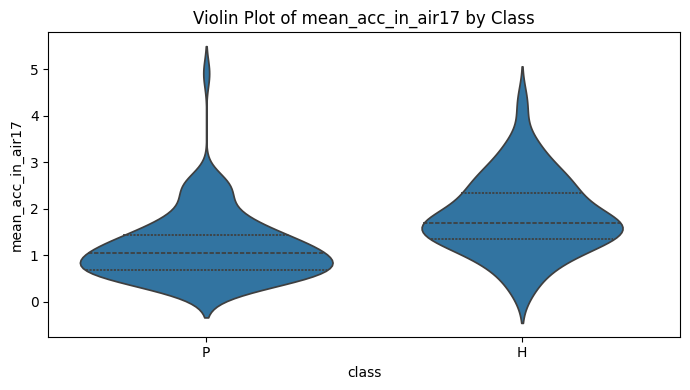

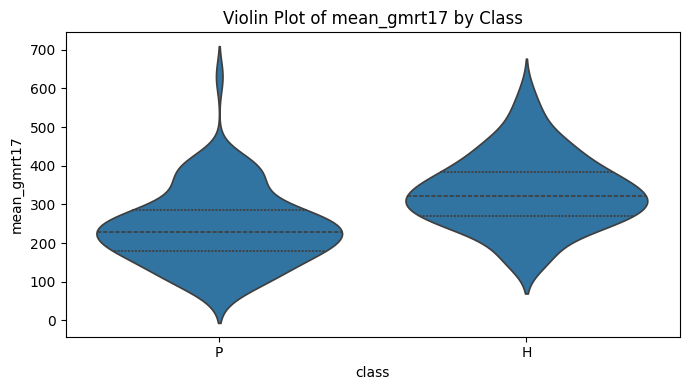

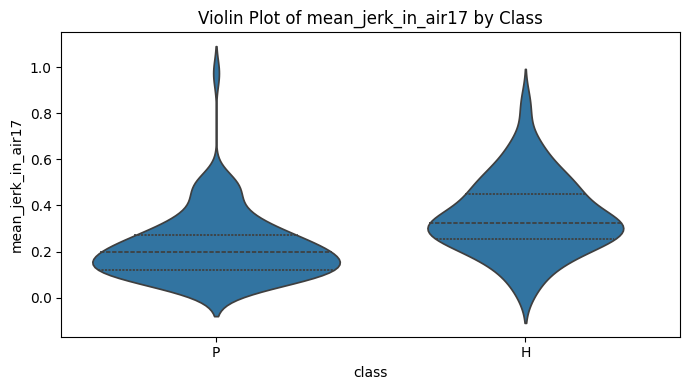

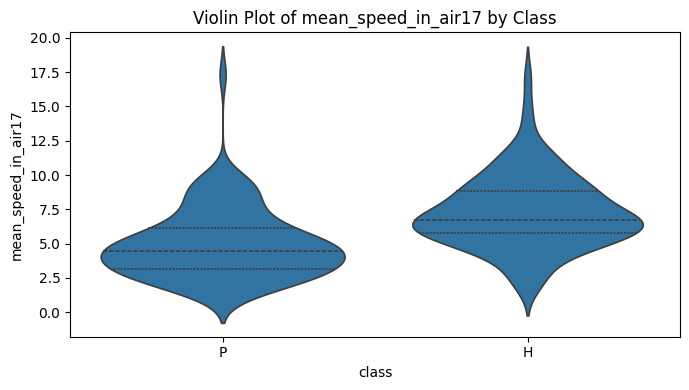

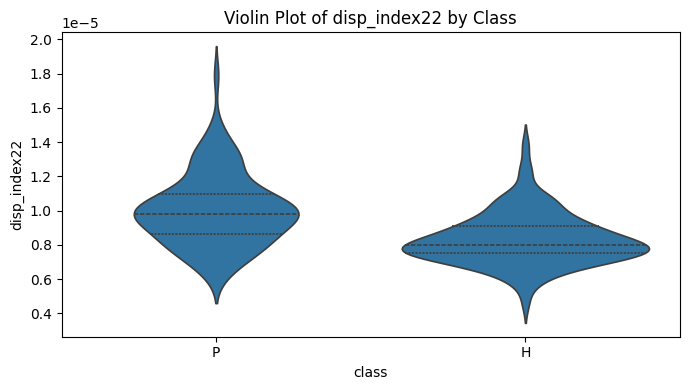

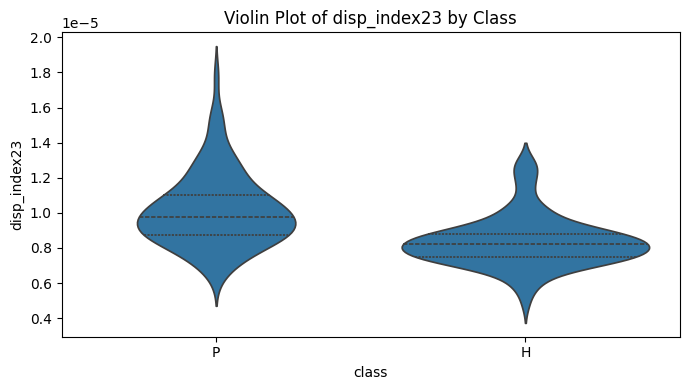

In [5]:
# Feature Selection (ANOVA)
float_cols = df.select_dtypes(include='float64').columns
X = df[float_cols].fillna(0)
y = df['class']
y_encoded = LabelEncoder().fit_transform(y)

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y_encoded)
top_features = X.columns[selector.get_support()].tolist()

print("Top Features:")
print(top_features)


# Plot top variables
for feature in top_features:
    plt.figure(figsize=(7, 4))
    sns.violinplot(x='class', y=feature, data=df, inner='quartile')
    plt.title(f'Violin Plot of {feature} by Class')
    plt.tight_layout()
    plt.show()

Records with >10 outlier features: 10


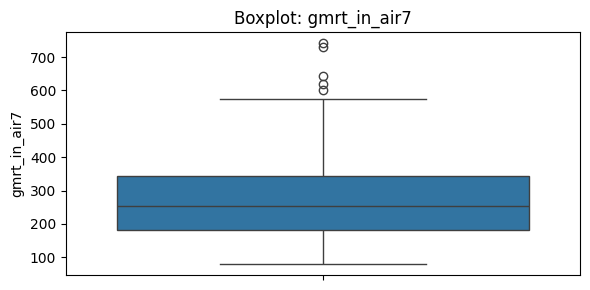

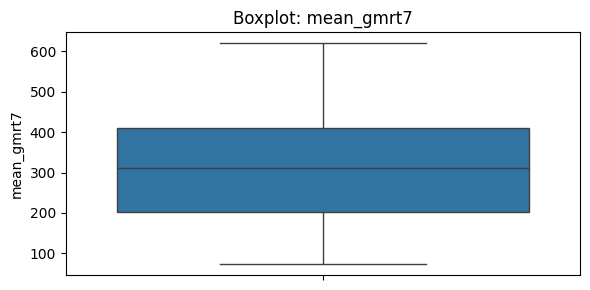

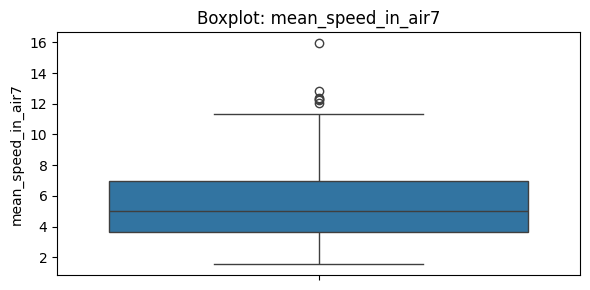

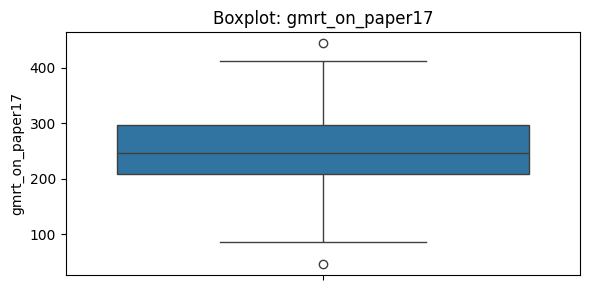

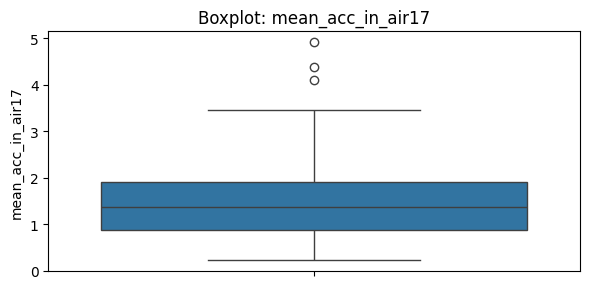

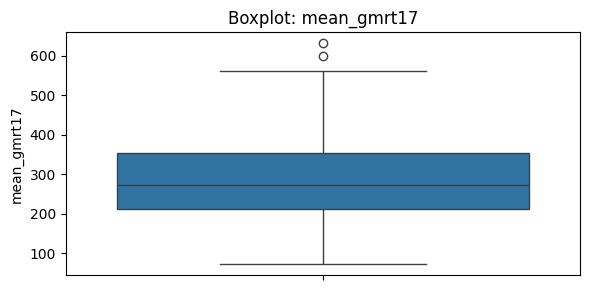

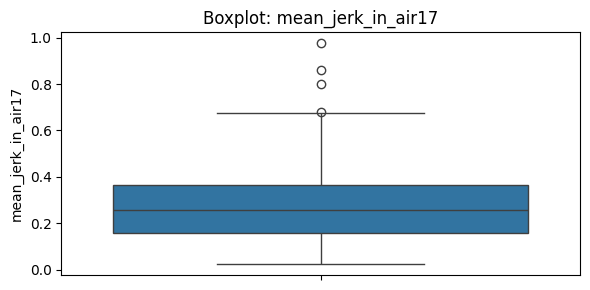

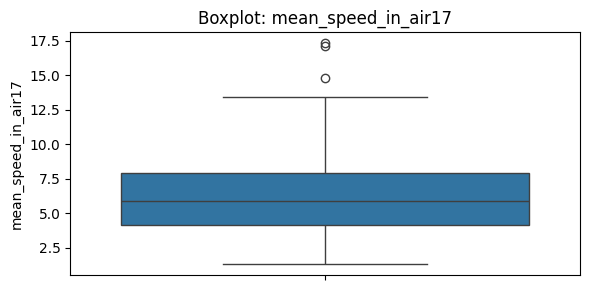

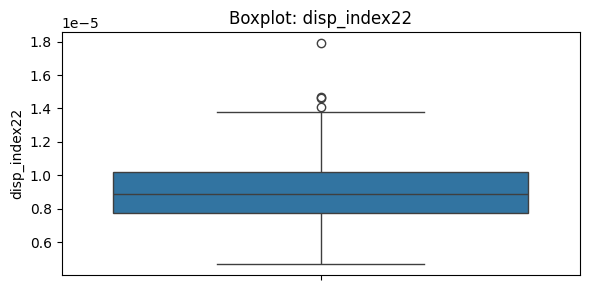

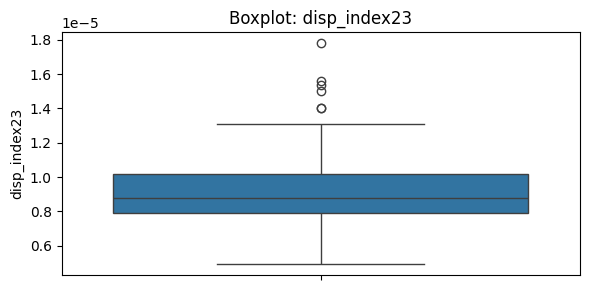

In [6]:
# Z-score-based outlier detection
z_scores = np.abs(zscore(X))
outlier_rows = (z_scores > 3).sum(axis=1)
df['num_outliers'] = outlier_rows

print(f"Records with >10 outlier features: {(outlier_rows > 10).sum()}")

# Boxplots for outliers
for col in top_features[:10]:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

gmrt_in_air7: p-value=0.0000 (not normal)
mean_gmrt7: p-value=0.0007 (not normal)
mean_speed_in_air7: p-value=0.0000 (not normal)
gmrt_on_paper17: p-value=0.7217 (normal)
mean_acc_in_air17: p-value=0.0000 (not normal)
mean_gmrt17: p-value=0.0420 (not normal)
mean_jerk_in_air17: p-value=0.0000 (not normal)
mean_speed_in_air17: p-value=0.0000 (not normal)
disp_index22: p-value=0.0000 (not normal)
disp_index23: p-value=0.0000 (not normal)


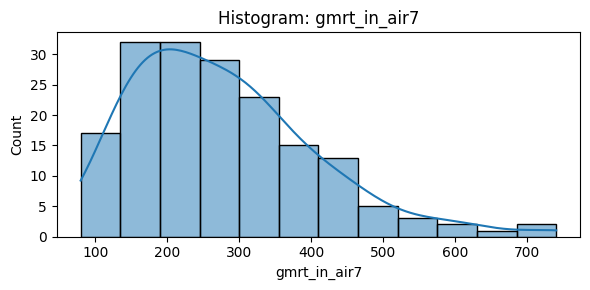

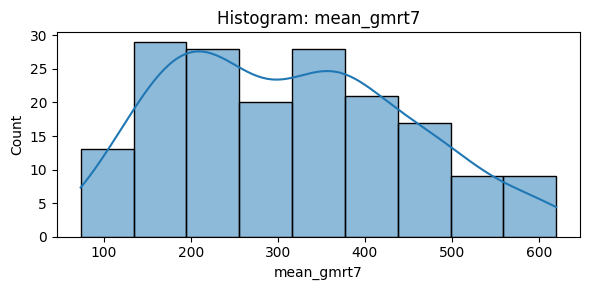

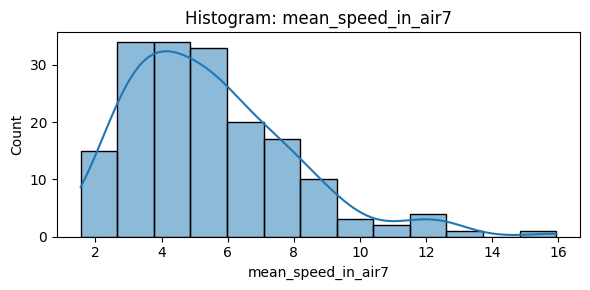

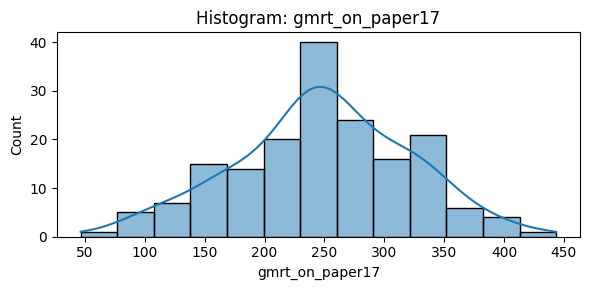

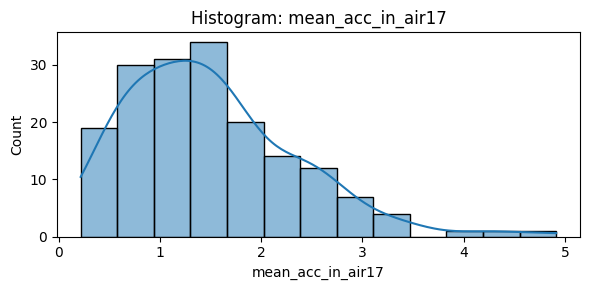

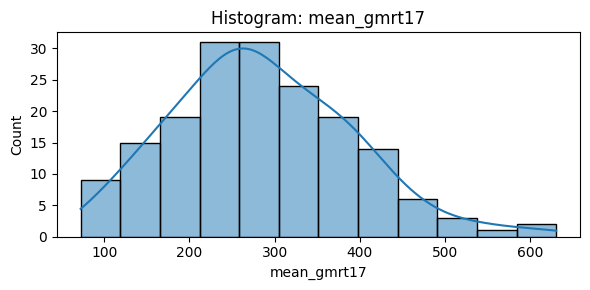

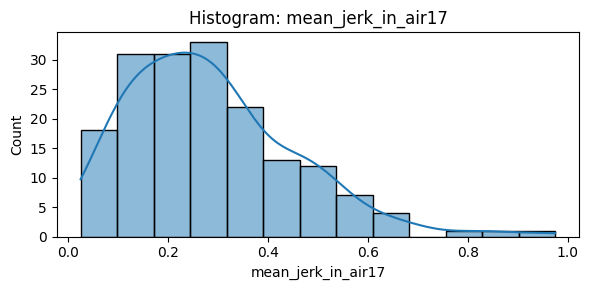

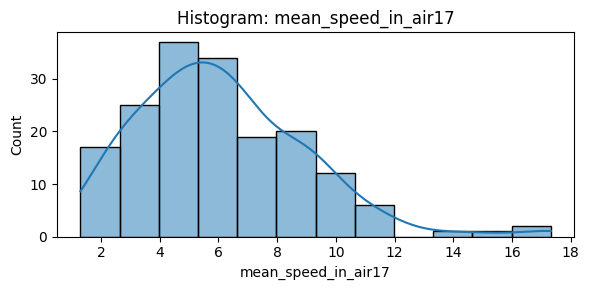

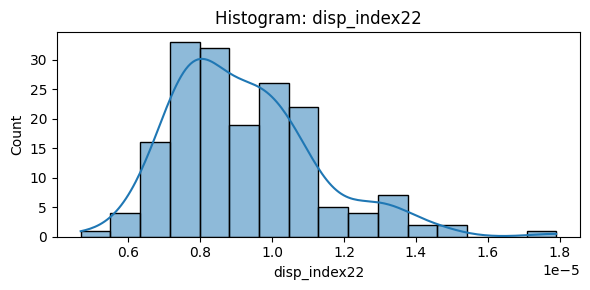

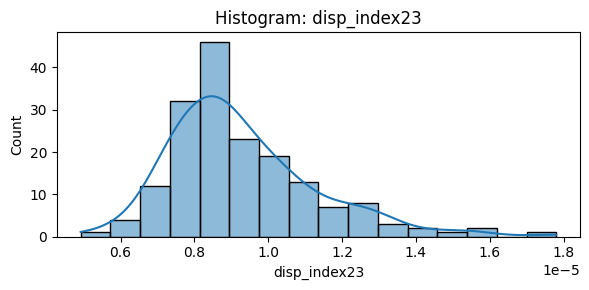

In [7]:
# Normality test on top variables
for col in top_features[:10]:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}: p-value={p:.4f} {'(not normal)' if p < 0.05 else '(normal)'}")

# Distribution histogram
for col in top_features[:10]:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    plt.show()